In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/custom.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))


# Chapter 3 — Exploratory Data Analysis (EDA)
## Lesson 5: Using Tools like Pandas, Matplotlib, and Seaborn

**Goal:** Become fluent with the three core tools used for tabular EDA in Python—**pandas** for data handling, **matplotlib** for foundational plotting, and **seaborn** for statistical visualization.

This lesson is deliberately hands-on and pragmatic. By the end, you should be able to open an unfamiliar CSV and:
1. Validate schema and data quality (types, missingness, duplicates, suspicious values).
2. Produce compact summary tables that answer concrete questions.
3. Convert those summaries into plots that communicate signal and risk.
4. Package your EDA steps into small reusable functions.

**Prerequisites:** basic Python syntax (variables, functions, lists/dicts), and familiarity with CSV files.

**What this lesson is not:** a catalog of every plotting option. Instead, it teaches a set of reliable patterns that scale to real projects.


### Datasets used in this lesson

To practice a realistic EDA workflow, we will intentionally work with **multiple datasets** from different folders (classification, regression, and clustering). This helps you learn how to adapt the same tools to different schemas.

We will use these repository paths:
- `../../../Datasets/Classification/iris.csv`
- `../../../Datasets/Classification/Wine_Quality.csv`
- `../../../Datasets/Regression/diamonds.csv`
- `../../../Datasets/Regression/house-prices.csv`
- `../../../Datasets/Clustering/airports.csv`
- `../../../Datasets/Regression/earthquake.csv`
- `../../../Datasets/Clustering/ConsumerComplaints.csv` (loaded partially)

If you cloned the repository and opened this notebook from `Tutorials/English/Chapter3/`, these paths should resolve.


### Why these tools matter in EDA

EDA is not a single chart or a single `.describe()` call. It is a **structured interrogation** of data quality, structure, and signal.

- **pandas** lets you answer: *What is in the dataset?* *Are types correct?* *Where are missing values?* *How do groups differ?* *What transformations are needed?*
- **matplotlib** gives you low-level control and a consistent mental model for plotting.
- **seaborn** builds on matplotlib and makes common statistical plots concise.

A good EDA workflow produces **actionable outcomes**: a shortlist of cleaning fixes, candidate features, risks (leakage-like columns, outliers, skew), and hypotheses worth testing.


### Setup: imports and display options

We will use a standard stack:
- `pandas` and `numpy` for data wrangling
- `matplotlib` for plotting primitives
- `seaborn` for statistical plots

In EDA, readability matters. We will set a few options so tables are easier to read.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

pd.set_option('display.max_columns', 60)
pd.set_option('display.width', 140)
pd.set_option('display.max_rows', 30)

sns.set_theme()
%matplotlib inline


### Loading datasets with consistent paths

In a multi-notebook repository, consistent relative paths are essential.
We will keep dataset paths in a small dictionary and use a helper function to load them.


In [3]:
DATASETS = {
    'iris': '../../../Datasets/Classification/iris.csv',
    'wine': '../../../Datasets/Classification/Wine_Quality.csv',
    'diamonds': '../../../Datasets/Regression/diamonds.csv',
    'house': '../../../Datasets/Regression/house-prices.csv',
    'airports': '../../../Datasets/Clustering/airports.csv',
    'earthquake': '../../../Datasets/Regression/earthquake.csv',
    'complaints': '../../../Datasets/Clustering/ConsumerComplaints.csv',
}

def load_csv(relative_path: str, **read_csv_kwargs) -> pd.DataFrame:
    path = Path(relative_path)
    if not path.exists():
        raise FileNotFoundError(
            f"File not found: {relative_path}\n"
            "Check that you opened the notebook from the repository structure and that the relative path is correct."
        )
    return pd.read_csv(path, **read_csv_kwargs)


## Part A — pandas essentials for EDA

pandas is your primary EDA workbench for tabular data.

A disciplined starting sequence is:
1. `head()` + `tail()` to see raw rows.
2. `info()` to confirm dtypes and missingness.
3. `describe()` to sanity-check ranges, centers, and dispersion.
4. `value_counts()` for categorical columns.
5. `isna().sum()` to quantify missingness.

We will start with Iris because it is small and clean, then move to messier datasets.


### 1) Load Iris and perform the first-pass inspection



In [4]:
iris = load_csv(DATASETS['iris'])
iris.head()


,sepal_length,sepal_width,petal_length,petal_width,classification
0,5.4,3.7,1.5,0.2,Iris-setosa
1,4.8,3.4,1.6,0.2,Iris-setosa
2,4.8,3.0,1.4,0.1,Iris-setosa
3,4.3,3.0,1.1,0.1,Iris-setosa
4,5.8,4.0,1.2,0.2,Iris-setosa


In [5]:
iris.tail()


,sepal_length,sepal_width,petal_length,petal_width,classification
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


In [6]:
iris.sample(5, random_state=7)


,sepal_length,sepal_width,petal_length,petal_width,classification
149,5.9,3.0,5.1,1.8,Iris-virginica
84,5.4,3.0,4.5,1.5,Iris-versicolor
40,5.0,3.5,1.3,0.3,Iris-setosa
66,5.6,3.0,4.5,1.5,Iris-versicolor
106,4.9,2.5,4.5,1.7,Iris-virginica


In [7]:
iris.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sepal_length    150 non-null    float64
 1   sepal_width     150 non-null    float64
 2   petal_length    150 non-null    float64
 3   petal_width     150 non-null    float64
 4   classification  150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [8]:
iris.describe(include='all')


,sepal_length,sepal_width,petal_length,petal_width,classification
count,150.000000,150.000000,150.000000,150.000000,150
unique,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,Iris-setosa
freq,NaN,NaN,NaN,NaN,50
mean,5.843333,3.054000,3.758667,1.198667,NaN
std,0.828066,0.433594,1.764420,0.763161,NaN
min,4.300000,2.000000,1.000000,0.100000,NaN
25%,5.100000,2.800000,1.600000,0.300000,NaN
50%,5.800000,3.000000,4.350000,1.300000,NaN
75%,6.400000,3.300000,5.100000,1.800000,NaN


In [9]:
iris.isna().sum()


sepal_length      0
sepal_width       0
petal_length      0
petal_width       0
classification    0
dtype: int64

In [10]:
iris['classification'].value_counts()


classification
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64

#### Interpretation: what `info()` and `describe()` tell you

For numeric columns, `.describe()` gives you **count, mean, std, min, quartiles, max**.

In EDA you typically check:
- Are there any impossible values? (e.g., negative lengths)
- Are scales reasonable? (e.g., centimeters vs millimeters)
- Are there strong skews? (mean far from median)

Quartiles are especially useful because they support robust outlier heuristics like the IQR rule.
If $Q_1$ is the 25th percentile and $Q_3$ is the 75th percentile, then $\text{IQR} = Q_3 - Q_1$.
A common outlier fence is:

$$[Q_1 - 1.5\cdot\text{IQR},\; Q_3 + 1.5\cdot\text{IQR}]$$

This is not a law of nature; it is a quick diagnostic.


### 2) Indexing, filtering, sorting, and method chaining

A productive EDA style is to write transformations as a readable sequence.
pandas supports this with method chaining:
- `df.query(...)`
- `df.assign(...)`
- `df.sort_values(...)`
- `df.groupby(...).agg(...)`

Below are a few common patterns.


In [11]:
iris_sorted = iris.sort_values(['classification', 'petal_length'], ascending=[True, False])
iris_sorted.head(8)


,sepal_length,sepal_width,petal_length,petal_width,classification
24,4.8,3.4,1.9,0.2,Iris-setosa
44,5.1,3.8,1.9,0.4,Iris-setosa
8,5.7,3.8,1.7,0.3,Iris-setosa
15,5.4,3.9,1.7,0.4,Iris-setosa
20,5.4,3.4,1.7,0.2,Iris-setosa
23,5.1,3.3,1.7,0.5,Iris-setosa
1,4.8,3.4,1.6,0.2,Iris-setosa
25,5.0,3.0,1.6,0.2,Iris-setosa


In [12]:
subset = (
    iris
    .query("classification != 'Iris-setosa'")
    .assign(petal_area=lambda d: d['petal_length'] * d['petal_width'])
    .sort_values('petal_area', ascending=False)
)
subset.head(10)


,sepal_length,sepal_width,petal_length,petal_width,classification,petal_area
118,7.7,2.6,6.9,2.3,Iris-virginica,15.87
109,7.2,3.6,6.1,2.5,Iris-virginica,15.25
100,6.3,3.3,6.0,2.5,Iris-virginica,15.00
117,7.7,3.8,6.7,2.2,Iris-virginica,14.74
144,6.7,3.3,5.7,2.5,Iris-virginica,14.25
135,7.7,3.0,6.1,2.3,Iris-virginica,14.03
105,7.6,3.0,6.6,2.1,Iris-virginica,13.86
143,6.8,3.2,5.9,2.3,Iris-virginica,13.57
136,6.3,3.4,5.6,2.4,Iris-virginica,13.44
140,6.7,3.1,5.6,2.4,Iris-virginica,13.44


In [13]:
group_stats = (
    iris
    .groupby('classification')
    .agg(
        n=('classification', 'size'),
        sepal_length_mean=('sepal_length', 'mean'),
        sepal_length_std=('sepal_length', 'std'),
        petal_length_mean=('petal_length', 'mean'),
        petal_width_mean=('petal_width', 'mean')
    )
)
group_stats


,n,sepal_length_mean,sepal_length_std,petal_length_mean,petal_width_mean
classification,,,,,
Iris-setosa,50,5.006,0.352490,1.464,0.244
Iris-versicolor,50,5.936,0.516171,4.260,1.326
Iris-virginica,50,6.588,0.635880,5.552,2.026


### 3) Missingness checks and type conversions

Missingness is rarely random in practice, and even a small missing rate can be important.

Two practical points:
1. Missing values can appear in *multiple encodings* (empty strings, 'N/A', '?', etc.).
2. A numeric column may be loaded as `object` if it contains stray non-numeric characters.

We will practice these checks on the airports dataset.


In [14]:
airports = load_csv(DATASETS['airports'])
airports.head()


,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,icao_code,iata_code,gps_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total RF Heliport,40.070985,-74.933689,11.0,NaN,US,US-PA,Bensalem,no,NaN,NaN,K00A,00A,https://www.penndot.pa.gov/TravelInPA/airports...,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,Leoti,no,NaN,NaN,00AA,00AA,NaN,NaN,NaN
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0,NaN,US,US-AK,Anchor Point,no,NaN,NaN,00AK,00AK,NaN,NaN,NaN
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,NaN,NaN,00AL,00AL,NaN,NaN,NaN
4,506791,00AN,small_airport,Katmai Lodge Airport,59.093287,-156.456699,80.0,NaN,US,US-AK,King Salmon,no,NaN,NaN,00AN,00AN,NaN,NaN,NaN


In [15]:
airports.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83125 entries, 0 to 83124
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 83125 non-null  int64  
 1   ident              83125 non-null  object 
 2   type               83125 non-null  object 
 3   name               83125 non-null  object 
 4   latitude_deg       83125 non-null  float64
 5   longitude_deg      83125 non-null  float64
 6   elevation_ft       68641 non-null  float64
 7   continent          43963 non-null  object 
 8   iso_country        82857 non-null  object 
 9   iso_region         83125 non-null  object 
 10  municipality       78437 non-null  object 
 11  scheduled_service  83125 non-null  object 
 12  icao_code          8637 non-null   object 
 13  iata_code          9079 non-null   object 
 14  gps_code           43288 non-null  object 
 15  local_code         35667 non-null  object 
 16  home_link          430

In [16]:
missing_counts = airports.isna().sum().sort_values(ascending=False)
missing_counts.head(20)


home_link            78820
icao_code            74488
iata_code            74046
wikipedia_link       66610
keywords             62888
local_code           47458
gps_code             39837
continent            39162
elevation_ft         14484
municipality          4688
iso_country            268
type                     0
ident                    0
id                       0
longitude_deg            0
iso_region               0
name                     0
latitude_deg             0
scheduled_service        0
dtype: int64

In [17]:
def hidden_missing_report(df: pd.DataFrame, candidates=('',' ','NA','N/A','?','None','null','NULL')):
    object_cols = df.select_dtypes(include=['object']).columns
    report = {}
    for c in object_cols:
        s = df[c].astype(str)
        hits = {v: int((s == v).sum()) for v in candidates}
        hits = {k: v for k, v in hits.items() if v > 0}
        if hits:
            report[c] = hits
    return report

hidden_missing_report(airports)


{}

A useful strategy is to standardize these encodings to real missing values (`NaN`) early, then rerun summaries and plots.


In [18]:
airports_clean = airports.replace({'': np.nan, ' ': np.nan, 'N/A': np.nan, 'NA': np.nan, '?': np.nan}).copy()
airports_clean.isna().sum().sort_values(ascending=False).head(15)


home_link         78820
icao_code         74488
iata_code         74046
wikipedia_link    66610
keywords          62888
local_code        47458
gps_code          39837
continent         39162
elevation_ft      14484
municipality       4688
iso_country         268
type                  0
ident                 0
id                    0
longitude_deg         0
dtype: int64

## Part B — matplotlib: from quick plots to the object-oriented API

matplotlib can be used in two styles:
- **stateful** (`plt.plot(...)`, `plt.title(...)`) which is quick for exploration
- **object-oriented (OO)** (`fig, ax = plt.subplots(); ax.plot(...)`) which scales better for complex figures

In production-grade notebooks, OO style is usually easier to maintain.


In [19]:
wine = load_csv(DATASETS['wine']).drop_duplicates().reset_index(drop=True)
wine.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6


### 1) Distribution plots (matplotlib)


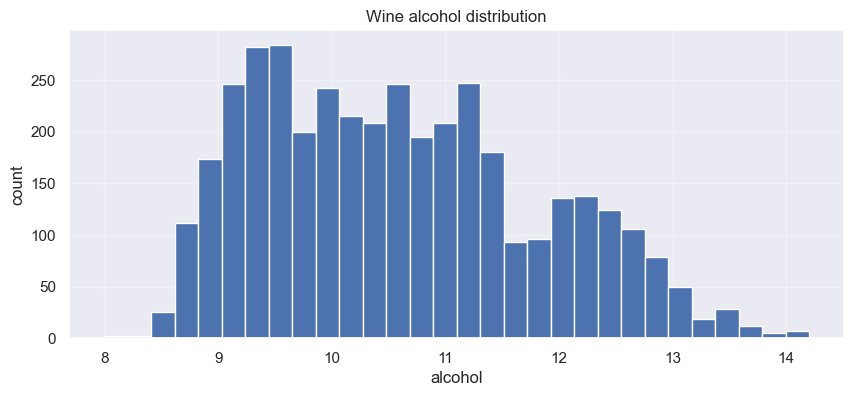

In [20]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(wine['alcohol'], bins=30)
ax.set_title('Wine alcohol distribution')
ax.set_xlabel('alcohol')
ax.set_ylabel('count')
ax.grid(True, alpha=0.3)
plt.show()


Sometimes you want the histogram to show *relative frequency* (density) rather than counts. A density histogram integrates to 1.


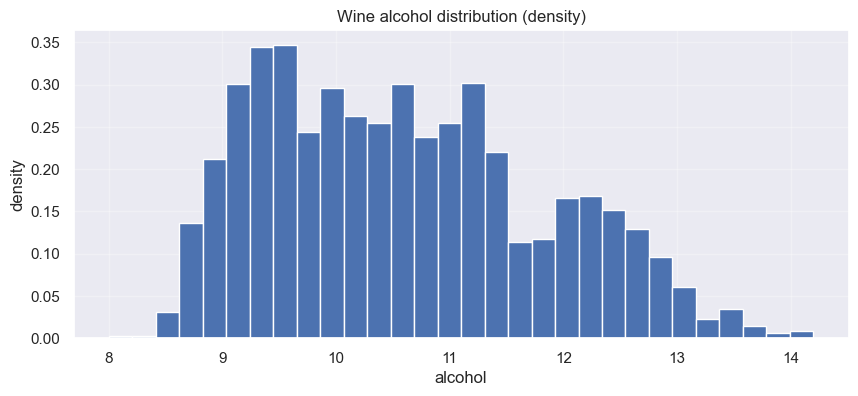

In [21]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(wine['alcohol'], bins=30, density=True)
ax.set_title('Wine alcohol distribution (density)')
ax.set_xlabel('alcohol')
ax.set_ylabel('density')
ax.grid(True, alpha=0.3)
plt.show()


### 2) Relationship plots and annotation


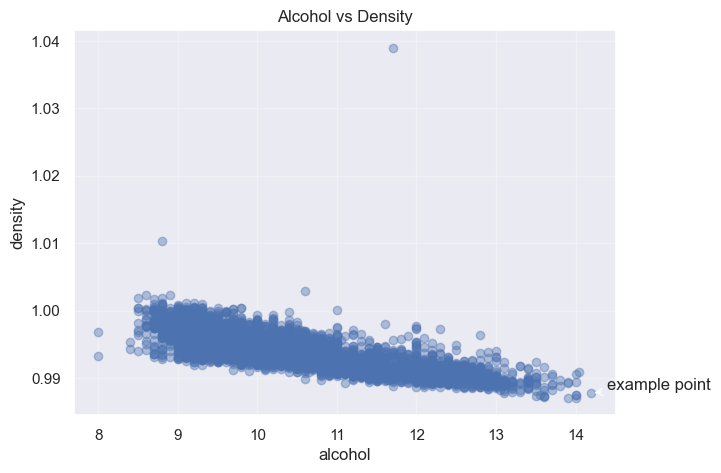

In [22]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(wine['alcohol'], wine['density'], alpha=0.4)
ax.set_title('Alcohol vs Density')
ax.set_xlabel('alcohol')
ax.set_ylabel('density')

# Annotate one extreme point to show the technique
idx = (wine['alcohol'] - wine['alcohol'].median()).abs().idxmax()
x0, y0 = wine.loc[idx, 'alcohol'], wine.loc[idx, 'density']
ax.annotate('example point', (x0, y0), xytext=(x0+0.2, y0+0.0005), arrowprops={'arrowstyle': '->'})
ax.grid(True, alpha=0.3)
plt.show()


### 3) Subplots for comparisons

A common EDA need is to compare distributions across groups.
One approach is to draw a small grid of histograms, one per group.


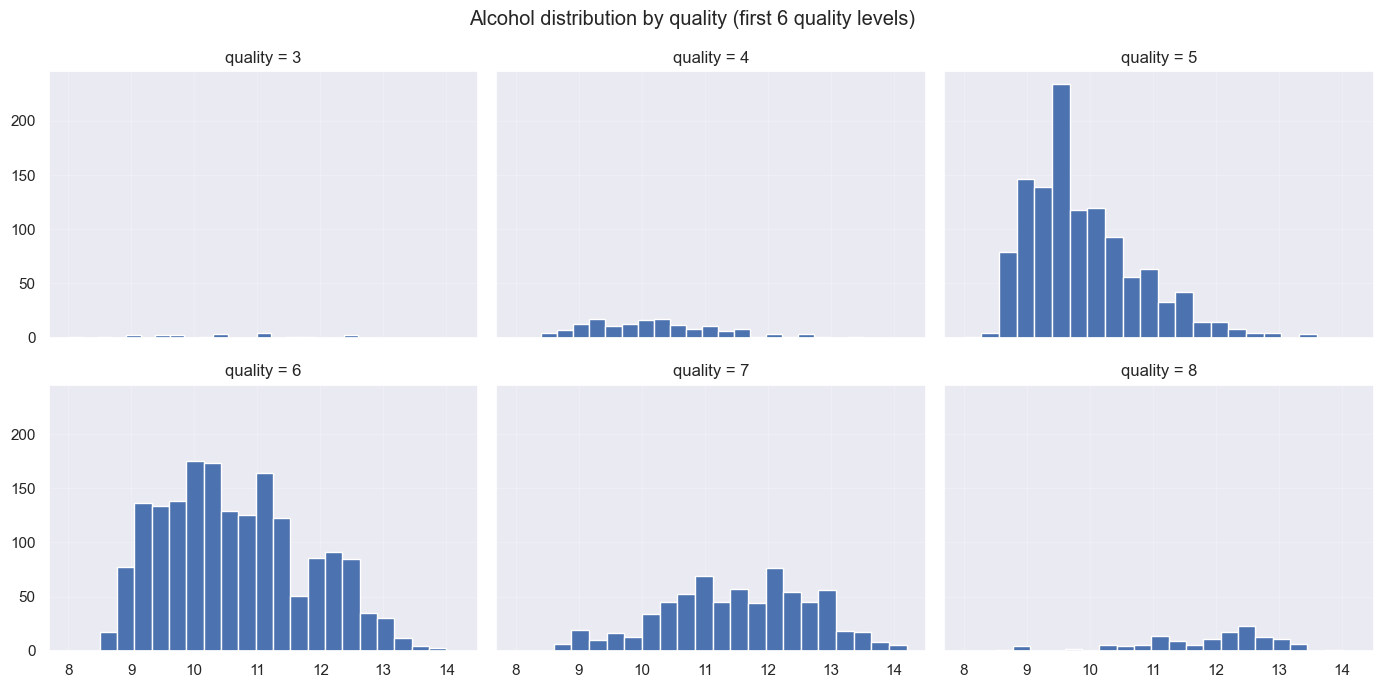

In [23]:
qualities = sorted(wine['quality'].unique())
fig, axes = plt.subplots(2, 3, figsize=(14, 7), sharex=True, sharey=True)
axes = axes.ravel()

for ax, q in zip(axes, qualities[:6]):
    ax.hist(wine.loc[wine['quality'] == q, 'alcohol'], bins=20)
    ax.set_title(f'quality = {q}')
    ax.grid(True, alpha=0.2)

fig.suptitle('Alcohol distribution by quality (first 6 quality levels)')
fig.tight_layout()
plt.show()


### 4) Saving figures for reports

Exporting figures is essential for reporting.
Use `dpi` for resolution and `bbox_inches='tight'` to reduce whitespace.


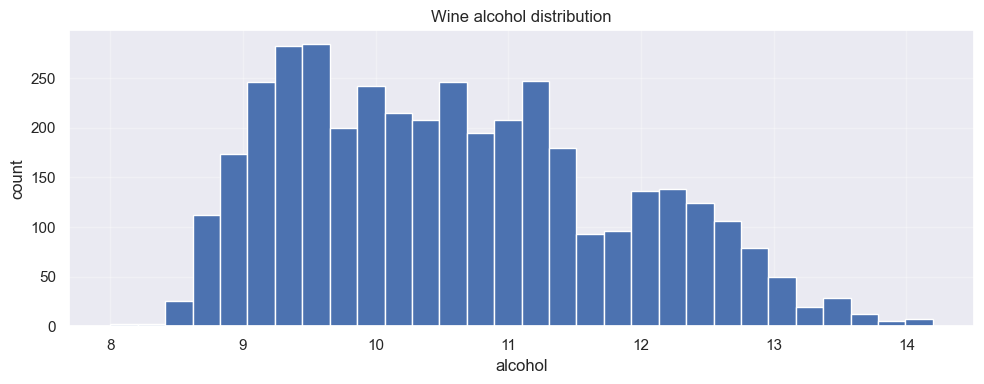

WindowsPath('outputs/wine_alcohol_hist.png')

In [24]:
outputs_dir = Path('outputs')
outputs_dir.mkdir(exist_ok=True)

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(wine['alcohol'], bins=30)
ax.set_title('Wine alcohol distribution')
ax.set_xlabel('alcohol')
ax.set_ylabel('count')
ax.grid(True, alpha=0.3)
fig.tight_layout()

out_path = outputs_dir / 'wine_alcohol_hist.png'
fig.savefig(out_path, dpi=160, bbox_inches='tight')
plt.show()
out_path


## Part C — seaborn: statistical visualization patterns

seaborn provides a higher-level interface for plots that are common in EDA.
In addition to the basic functions, seaborn offers **faceting** (small multiples) through `FacetGrid`, `relplot`, and `catplot`.

In this section you will practice:
- distribution plots (`histplot`, `kdeplot`)
- group comparisons (`boxplot`, `violinplot`)
- relationship plots with categorical hues (`scatterplot`, `regplot`)
- correlation heatmaps
- faceted plots for quick comparisons


### 1) Distribution: histplot + KDE


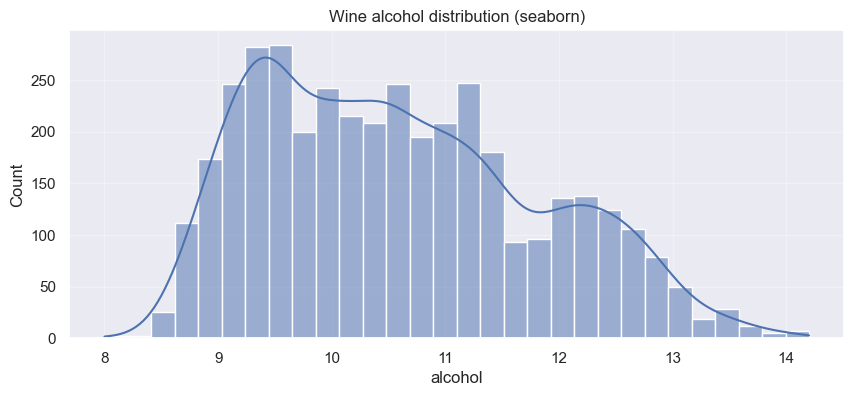

In [25]:
plt.figure(figsize=(10, 4))
sns.histplot(wine['alcohol'], bins=30, kde=True)
plt.title('Wine alcohol distribution (seaborn)')
plt.grid(True, alpha=0.3)
plt.show()


### 2) Group comparisons: boxplot and violinplot


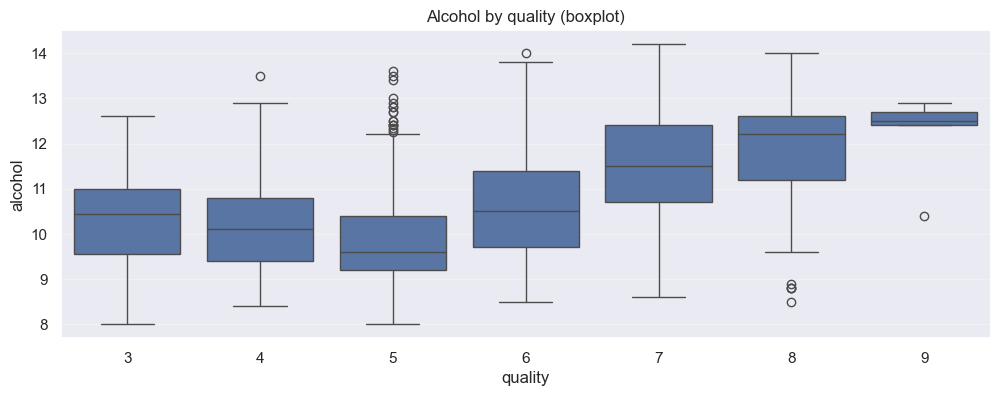

In [26]:
plt.figure(figsize=(12, 4))
sns.boxplot(data=wine, x='quality', y='alcohol')
plt.title('Alcohol by quality (boxplot)')
plt.grid(True, axis='y', alpha=0.3)
plt.show()


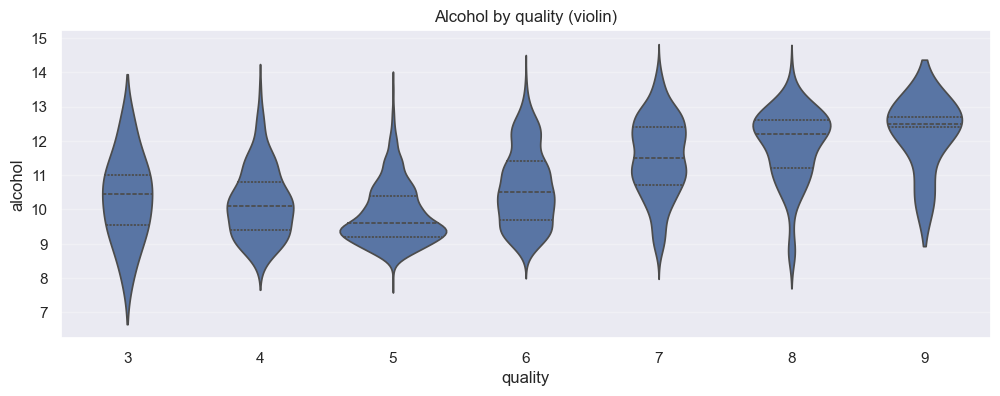

In [27]:
plt.figure(figsize=(12, 4))
sns.violinplot(data=wine, x='quality', y='alcohol', inner='quartile')
plt.title('Alcohol by quality (violin)')
plt.grid(True, axis='y', alpha=0.3)
plt.show()


### 3) Relationship plots: scatterplot + regression


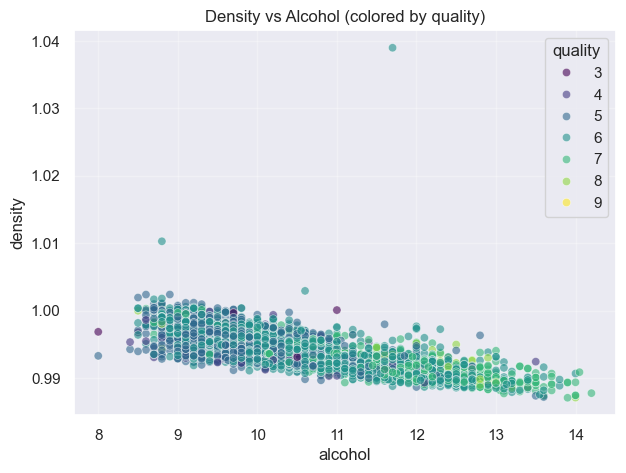

In [28]:
plt.figure(figsize=(7, 5))
sns.scatterplot(data=wine, x='alcohol', y='density', hue='quality', palette='viridis', alpha=0.6)
plt.title('Density vs Alcohol (colored by quality)')
plt.grid(True, alpha=0.3)
plt.show()


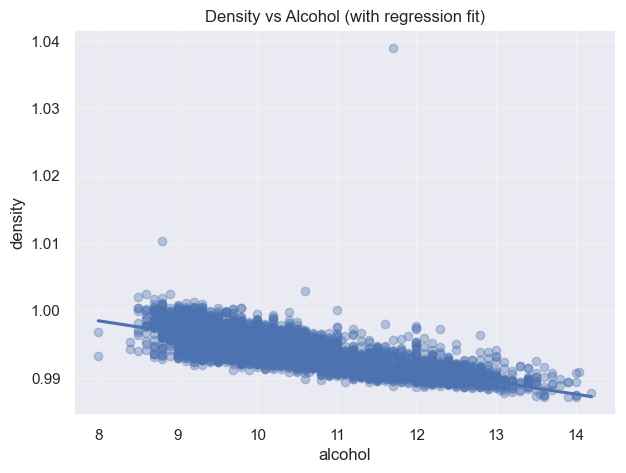

In [29]:
plt.figure(figsize=(7, 5))
sns.regplot(data=wine, x='alcohol', y='density', scatter_kws={'alpha': 0.35})
plt.title('Density vs Alcohol (with regression fit)')
plt.grid(True, alpha=0.3)
plt.show()


### 4) Correlation heatmap (with masking)

When you plot a full correlation matrix, it can be visually dense.
A common trick is to mask the upper triangle.


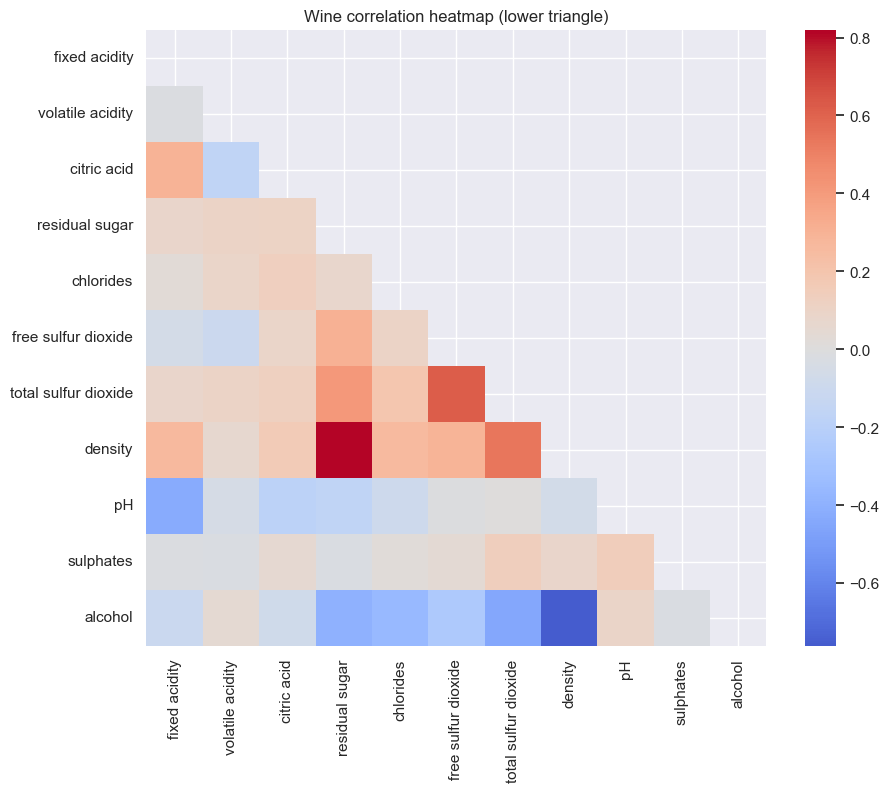

In [30]:
corr = wine.drop(columns=['quality']).corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0)
plt.title('Wine correlation heatmap (lower triangle)')
plt.show()


### 5) Faceting with `catplot`: alcohol distribution across quality

Faceting is an efficient way to compare many groups without manually writing loops.


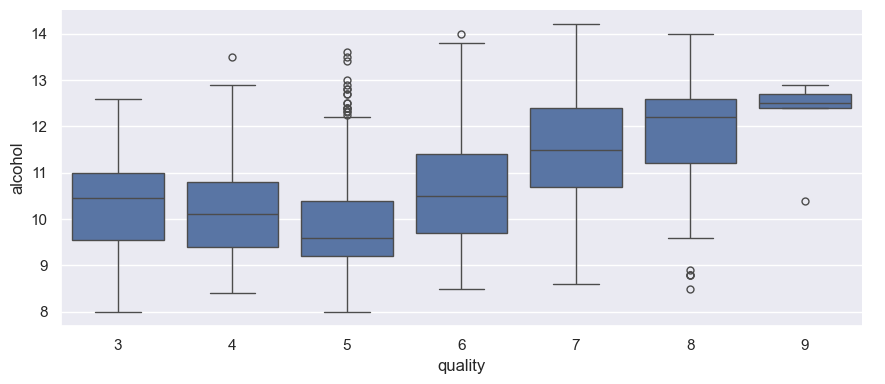

In [31]:
sns.catplot(data=wine, x='quality', y='alcohol', kind='box', height=4, aspect=2.2)


## Part D — pandas reshaping and analysis patterns

As datasets get more complex, you will often need to reshape them.

Key operations:
- `melt` converts wide → long (tidy format).
- `pivot_table` converts long → wide summaries.
- `crosstab` builds contingency tables.
- `cut` / `qcut` create bins for continuous features.

These tools matter because many plotting functions expect tidy data.


### 1) Wide → long with `melt` (Iris)


In [32]:
iris_long = iris.melt(id_vars='classification', var_name='feature', value_name='value')
iris_long.head()


,classification,feature,value
0,Iris-setosa,sepal_length,5.4
1,Iris-setosa,sepal_length,4.8
2,Iris-setosa,sepal_length,4.8
3,Iris-setosa,sepal_length,4.3
4,Iris-setosa,sepal_length,5.8


In [33]:
iris_long.groupby(['classification', 'feature']).agg(mean=('value','mean'), std=('value','std')).head(12)


mean       std
classification  feature                      
Iris-setosa     petal_length  1.464  0.173511
                petal_width   0.244  0.107210
                sepal_length  5.006  0.352490
                sepal_width   3.418  0.381024
Iris-versicolor petal_length  4.260  0.469911
                petal_width   1.326  0.197753
                sepal_length  5.936  0.516171
                sepal_width   2.770  0.313798
Iris-virginica  petal_length  5.552  0.551895
                petal_width   2.026  0.274650
                sepal_length  6.588  0.635880
                sepal_width   2.974  0.322497

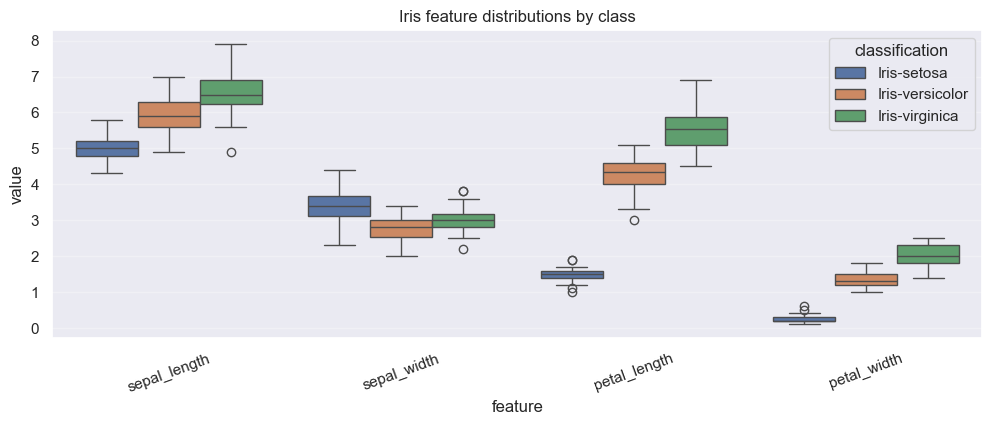

In [34]:
plt.figure(figsize=(12, 4))
sns.boxplot(data=iris_long, x='feature', y='value', hue='classification')
plt.title('Iris feature distributions by class')
plt.xticks(rotation=20)
plt.grid(True, axis='y', alpha=0.3)
plt.show()


### 2) Binning with `qcut`: alcohol quantiles (Wine)


In [35]:
wine_bins = wine.copy()
wine_bins['alcohol_bin'] = pd.qcut(wine_bins['alcohol'], q=4, duplicates='drop')
wine_bins[['alcohol', 'alcohol_bin']].head()


,alcohol,alcohol_bin
0,8.8,"(7.999, 9.5]"
1,9.5,"(7.999, 9.5]"
2,10.1,"(9.5, 10.4]"
3,9.9,"(9.5, 10.4]"
4,9.6,"(9.5, 10.4]"


In [36]:
bin_quality = pd.crosstab(wine_bins['alcohol_bin'], wine_bins['quality'], normalize='index')
bin_quality.round(3)


quality,3,4,5,6,7,8,9
alcohol_bin,,,,,,,
"(7.999, 9.5]",0.005,0.048,0.544,0.355,0.043,0.005,0.000
"(9.5, 10.4]",0.005,0.050,0.352,0.503,0.081,0.007,0.001
"(10.4, 11.4]",0.006,0.037,0.213,0.509,0.208,0.027,0.000
"(11.4, 14.2]",0.004,0.019,0.067,0.442,0.369,0.095,0.004


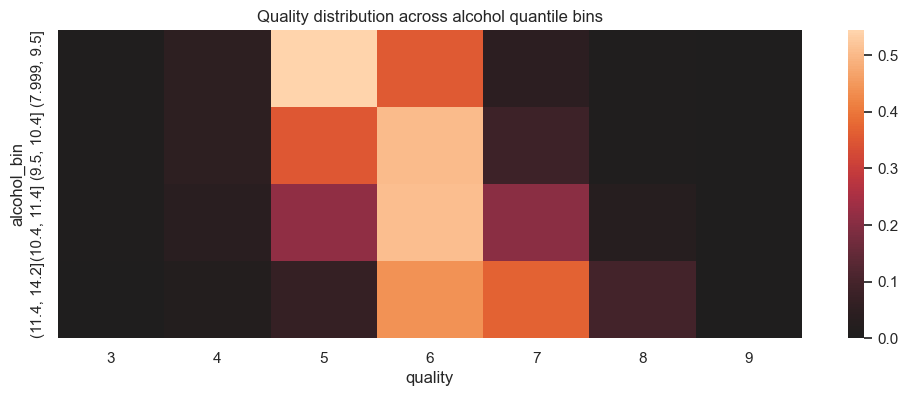

In [37]:
plt.figure(figsize=(12, 4))
sns.heatmap(bin_quality, center=0)
plt.title('Quality distribution across alcohol quantile bins')
plt.show()


### 3) Contingency tables with `crosstab` (Diamonds)


In [38]:
diamonds = load_csv(DATASETS['diamonds'])
diamonds[['cut', 'color', 'clarity']] = diamonds[['cut', 'color', 'clarity']].astype('category')
diamonds.head()


,id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [39]:
cut_color_counts = pd.crosstab(diamonds['cut'], diamonds['color'])
cut_color_counts


color,D,E,F,G,H,I,J
cut,,,,,,,
Fair,163,224,312,314,303,175,119
Good,662,933,909,871,702,522,307
Ideal,2834,3903,3826,4884,3115,2093,896
Premium,1603,2337,2331,2924,2360,1428,808
Very Good,1513,2400,2164,2299,1824,1204,678


In [40]:
cut_color_props = pd.crosstab(diamonds['cut'], diamonds['color'], normalize='index')
cut_color_props.round(3)


color,D,E,F,G,H,I,J
cut,,,,,,,
Fair,0.101,0.139,0.194,0.195,0.188,0.109,0.074
Good,0.135,0.190,0.185,0.178,0.143,0.106,0.063
Ideal,0.132,0.181,0.178,0.227,0.145,0.097,0.042
Premium,0.116,0.169,0.169,0.212,0.171,0.104,0.059
Very Good,0.125,0.199,0.179,0.190,0.151,0.100,0.056


## Part E — dates, times, and time-based aggregation with pandas

A large share of applied ML work involves time: events, transactions, logs, sensor readings.

For EDA, you need to:
- parse timestamps reliably
- extract time components (hour, day-of-week, month)
- resample or aggregate by time windows

We will use the earthquake dataset as a compact example.


In [41]:
eq = load_csv(DATASETS['earthquake'])
eq.head()


,date,time,latitude,longitude,depth,magnitude
0,2008-11-01,00:31:25,-0.60,98.89553,20.0,2.99
1,2008-11-01,01:34:29,-6.61,129.38722,30.1,5.51
2,2008-11-01,01:38:14,-3.65,127.99068,5.0,3.54
3,2008-11-01,02:20:05,-4.20,128.09700,5.0,2.42
4,2008-11-01,02:32:18,-4.09,128.20047,10.0,2.41


In [42]:
eq['timestamp'] = pd.to_datetime(eq['date'].astype(str) + ' ' + eq['time'].astype(str), errors='coerce')
eq[['date', 'time', 'timestamp']].head()


,date,time,timestamp
0,2008-11-01,00:31:25,2008-11-01 00:31:25
1,2008-11-01,01:34:29,2008-11-01 01:34:29
2,2008-11-01,01:38:14,2008-11-01 01:38:14
3,2008-11-01,02:20:05,2008-11-01 02:20:05
4,2008-11-01,02:32:18,2008-11-01 02:32:18


In [43]:
eq.isna().sum()


date         0
time         0
latitude     0
longitude    0
depth        0
magnitude    0
timestamp    0
dtype: int64

In [44]:
eq = eq.dropna(subset=['timestamp']).copy()
eq['year'] = eq['timestamp'].dt.year
eq['month'] = eq['timestamp'].dt.month
eq['dayofweek'] = eq['timestamp'].dt.dayofweek
eq[['timestamp', 'year', 'month', 'dayofweek']].head()


,timestamp,year,month,dayofweek
0,2008-11-01 00:31:25,2008,11,5
1,2008-11-01 01:34:29,2008,11,5
2,2008-11-01 01:38:14,2008,11,5
3,2008-11-01 02:20:05,2008,11,5
4,2008-11-01 02:32:18,2008,11,5


In [45]:
daily_counts = eq.set_index('timestamp').resample('D').size()
daily_counts.head(10)


timestamp
2008-11-01    19
2008-11-02     6
2008-11-03    17
2008-11-04     9
2008-11-05     6
2008-11-06     5
2008-11-07    15
2008-11-08     9
2008-11-09     5
2008-11-10    15
Freq: D, dtype: int64

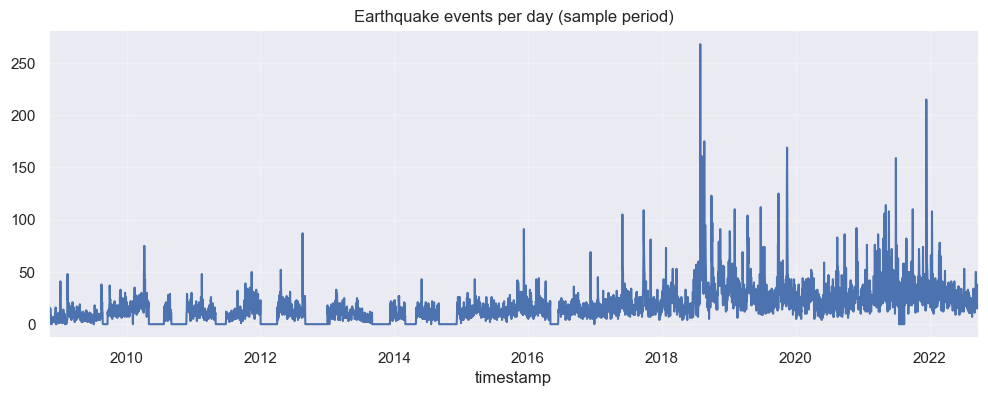

In [46]:
plt.figure(figsize=(12, 4))
daily_counts.plot()
plt.title('Earthquake events per day (sample period)')
plt.grid(True, alpha=0.3)
plt.show()


When counts are sparse, a weekly resample often makes trends easier to see.


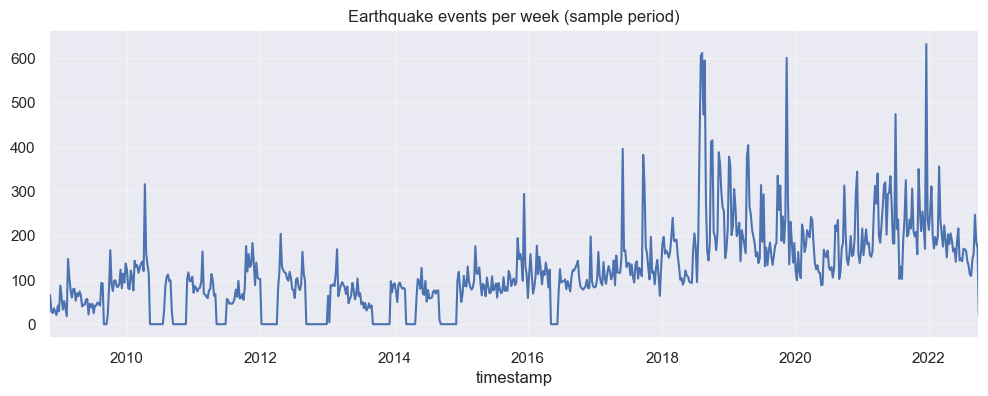

In [47]:
weekly_counts = eq.set_index('timestamp').resample('W').size()
plt.figure(figsize=(12, 4))
weekly_counts.plot()
plt.title('Earthquake events per week (sample period)')
plt.grid(True, alpha=0.3)
plt.show()


## Part F — text-heavy tables and partial loading

Some datasets have very wide text columns (e.g., narratives or descriptions).
For EDA, you often start by loading only a subset of rows to inspect schema and missingness.

Here we load a limited number of rows from the consumer complaints dataset and perform basic quality checks.


In [48]:
complaints = load_csv(DATASETS['complaints'], nrows=5000)
complaints.head()


,Date Received,Product Name,Sub Product,Issue,Sub Issue,Consumer Complaint Narrative,Company Public Response,Company,State Name,Zip Code,Tags,Consumer Consent Provided,Submitted via,Date Sent to Company,Company Response to Consumer,Timely Response,Consumer Disputed,Complaint ID
0,2013-07-29,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,NaN,NaN,Wells Fargo & Company,VA,24540.0,NaN,NaN,Phone,2013-07-30,Closed with explanation,Yes,No,468882
1,2013-07-29,Bank account or service,Checking account,Using a debit or ATM card,NaN,NaN,NaN,Wells Fargo & Company,CA,95992.0,Older American,NaN,Web,2013-07-31,Closed with explanation,Yes,No,468889
2,2013-07-29,Bank account or service,Checking account,"Account opening, closing, or management",NaN,NaN,NaN,Santander Bank US,NY,10065.0,NaN,NaN,Fax,2013-07-31,Closed,Yes,No,468879
3,2013-07-29,Bank account or service,Checking account,Deposits and withdrawals,NaN,NaN,NaN,Wells Fargo & Company,GA,30084.0,NaN,NaN,Web,2013-07-30,Closed with explanation,Yes,No,468949
4,2013-07-29,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Franklin Credit Management,CT,6106.0,NaN,NaN,Web,2013-07-30,Closed with explanation,Yes,No,475823


In [49]:
complaints.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Date Received                 5000 non-null   object 
 1   Product Name                  5000 non-null   object 
 2   Sub Product                   3693 non-null   object 
 3   Issue                         5000 non-null   object 
 4   Sub Issue                     1613 non-null   object 
 5   Consumer Complaint Narrative  0 non-null      float64
 6   Company Public Response       0 non-null      float64
 7   Company                       5000 non-null   object 
 8   State Name                    4972 non-null   object 
 9   Zip Code                      4972 non-null   float64
 10  Tags                          746 non-null    object 
 11  Consumer Consent Provided     0 non-null      float64
 12  Submitted via                 5000 non-null   object 
 13  Dat

In [50]:
complaints.isna().mean().sort_values(ascending=False).head(15)


Company Public Response         1.0000
Consumer Complaint Narrative    1.0000
Consumer Consent Provided       1.0000
Tags                            0.8508
Sub Issue                       0.6774
Sub Product                     0.2614
Consumer Disputed               0.0096
Zip Code                        0.0056
State Name                      0.0056
Date Received                   0.0000
Product Name                    0.0000
Issue                           0.0000
Company                         0.0000
Submitted via                   0.0000
Date Sent to Company            0.0000
dtype: float64

In [51]:
complaints['Product Name'].value_counts().head(15)


Product Name
Mortgage                   2055
Debt collection             773
Credit reporting            715
Credit card                 592
Bank account or service     577
Consumer Loan               136
Student loan                125
Money transfers              27
Name: count, dtype: int64

In [52]:
complaints['Date Received'] = pd.to_datetime(complaints['Date Received'], errors='coerce')
complaints['year'] = complaints['Date Received'].dt.year
complaints['month'] = complaints['Date Received'].dt.month
complaints[['Date Received', 'year', 'month']].head()


,Date Received,year,month
0,2013-07-29,2013,7
1,2013-07-29,2013,7
2,2013-07-29,2013,7
3,2013-07-29,2013,7
4,2013-07-29,2013,7


C:\Users\LENOVO.PIESC\AppData\Local\Temp\ipykernel_21812\466697075.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = complaints.dropna(subset=['Date Received']).set_index('Date Received').resample('M').size()


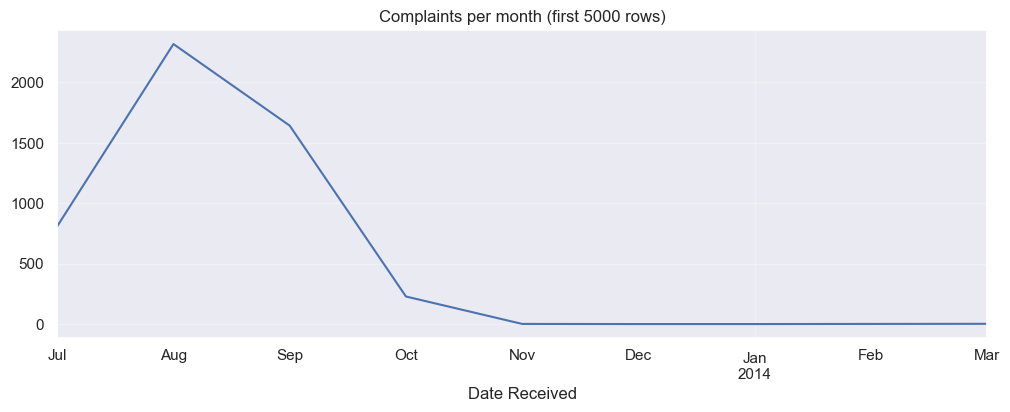

In [53]:
monthly = complaints.dropna(subset=['Date Received']).set_index('Date Received').resample('M').size()
plt.figure(figsize=(12, 4))
monthly.plot()
plt.title('Complaints per month (first 5000 rows)')
plt.grid(True, alpha=0.3)
plt.show()


## Part G — packaging EDA into reusable helpers

As you repeat the same checks across datasets, it is worth creating small helpers.

We will create:
- `eda_quick_report`: schema, missingness, duplicates, sample rows, numeric summary
- `eda_plot_suite`: standard set of plots

These functions are intentionally compact and can be copied into other notebooks.


In [54]:
def eda_quick_report(df: pd.DataFrame, *, title: str, target: str | None = None, sample: int = 5):
    print('=' * 100)
    print(title)
    print('-' * 100)
    print('Shape:', df.shape)
    print('Duplicates:', int(df.duplicated().sum()))
    
    print('\nMissing values (top 12):')
    display(df.isna().sum().sort_values(ascending=False).head(12))
    
    print('\nDtypes:')
    display(df.dtypes)
    
    print('\nSample rows:')
    display(df.sample(min(sample, len(df)), random_state=42))
    
    numeric = df.select_dtypes(include=[np.number])
    if numeric.shape[1] > 0:
        print('\nNumeric summary:')
        display(numeric.describe().T)
    
    if target is not None and target in df.columns:
        print(f"\nTarget distribution for '{target}':")
        display(df[target].value_counts(dropna=False).head(25))

eda_quick_report(wine, title='Wine dataset quick report', target='quality')


Wine dataset quick report
----------------------------------------------------------------------------------------------------
Shape: (3961, 12)
Duplicates: 0

Missing values (top 12):


fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


Dtypes:


fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object


Sample rows:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
149,7.2,0.32,0.47,5.1,0.044,19.0,65.0,0.9910,3.03,0.41,12.6,4
1025,9.7,0.24,0.45,1.2,0.033,11.0,59.0,0.9926,2.74,0.47,10.8,6
1288,7.2,0.27,0.74,12.5,0.037,47.0,156.0,0.9981,3.04,0.44,8.7,5
720,4.8,0.34,0.00,6.5,0.028,33.0,163.0,0.9939,3.36,0.61,9.9,6
325,5.0,0.17,0.56,1.5,0.026,24.0,115.0,0.9906,3.48,0.39,10.8,7



Numeric summary:


,count,mean,std,min,25%,50%,75%,max
fixed acidity,3961.0,6.839346,0.866860,3.80000,6.30000,6.8000,7.30000,14.20000
volatile acidity,3961.0,0.280538,0.103437,0.08000,0.21000,0.2600,0.33000,1.10000
citric acid,3961.0,0.334332,0.122446,0.00000,0.27000,0.3200,0.39000,1.66000
residual sugar,3961.0,5.914819,4.861646,0.60000,1.60000,4.7000,8.90000,65.80000
chlorides,3961.0,0.045905,0.023103,0.00900,0.03500,0.0420,0.05000,0.34600
free sulfur dioxide,3961.0,34.889169,17.210021,2.00000,23.00000,33.0000,45.00000,289.00000
total sulfur dioxide,3961.0,137.193512,43.129065,9.00000,106.00000,133.0000,166.00000,440.00000
density,3961.0,0.993790,0.002905,0.98711,0.99162,0.9935,0.99571,1.03898
pH,3961.0,3.195458,0.151546,2.72000,3.09000,3.1800,3.29000,3.82000
sulphates,3961.0,0.490351,0.113523,0.22000,0.41000,0.4800,0.55000,1.08000



Target distribution for 'quality':


quality
6    1788
5    1175
7     689
4     153
8     131
3      20
9       5
Name: count, dtype: int64

House plot suite


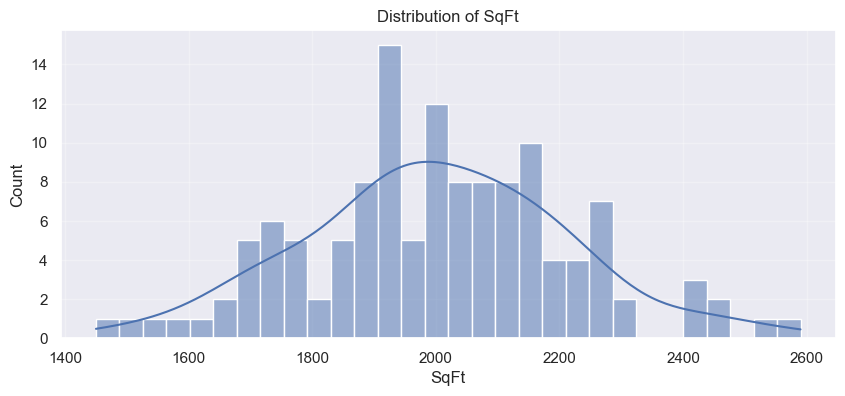

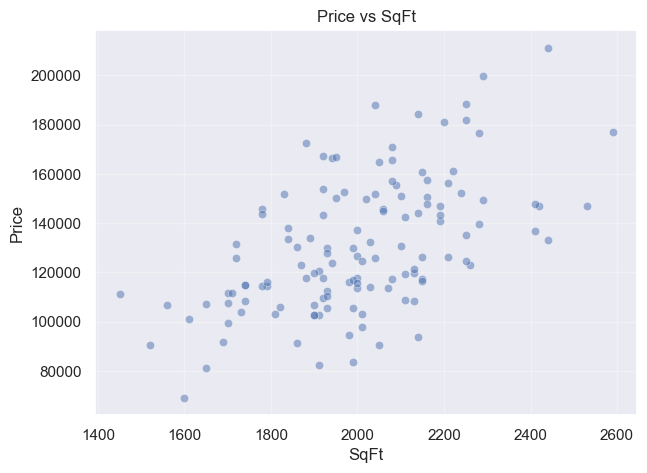

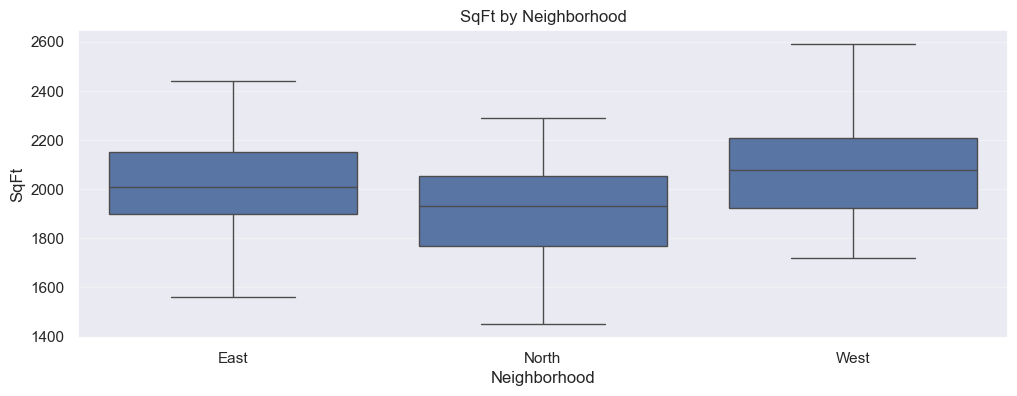

In [55]:
def eda_plot_suite(df: pd.DataFrame, *, numeric_a: str, numeric_b: str, category: str | None = None, title: str = ''):
    if title:
        print(title)
    
    # Distribution
    plt.figure(figsize=(10, 4))
    sns.histplot(df[numeric_a].dropna(), bins=30, kde=True)
    plt.title(f'Distribution of {numeric_a}')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Relationship
    plt.figure(figsize=(7, 5))
    sns.scatterplot(data=df, x=numeric_a, y=numeric_b, alpha=0.5)
    plt.title(f'{numeric_b} vs {numeric_a}')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Group comparison
    if category is not None and category in df.columns:
        plt.figure(figsize=(12, 4))
        sns.boxplot(data=df, x=category, y=numeric_a)
        plt.title(f'{numeric_a} by {category}')
        plt.grid(True, axis='y', alpha=0.3)
        plt.show()

eda_plot_suite(house := load_csv(DATASETS['house']), numeric_a='SqFt', numeric_b='Price', category='Neighborhood', title='House plot suite')


### Pairwise relationships at a glance: `pairplot` (Iris)

`pairplot` is one of the fastest ways to see whether classes are separable in feature space.
If you observe clear separation, linear or simple models often work well; if the clouds overlap heavily, you may need nonlinear models, better features, or more data.


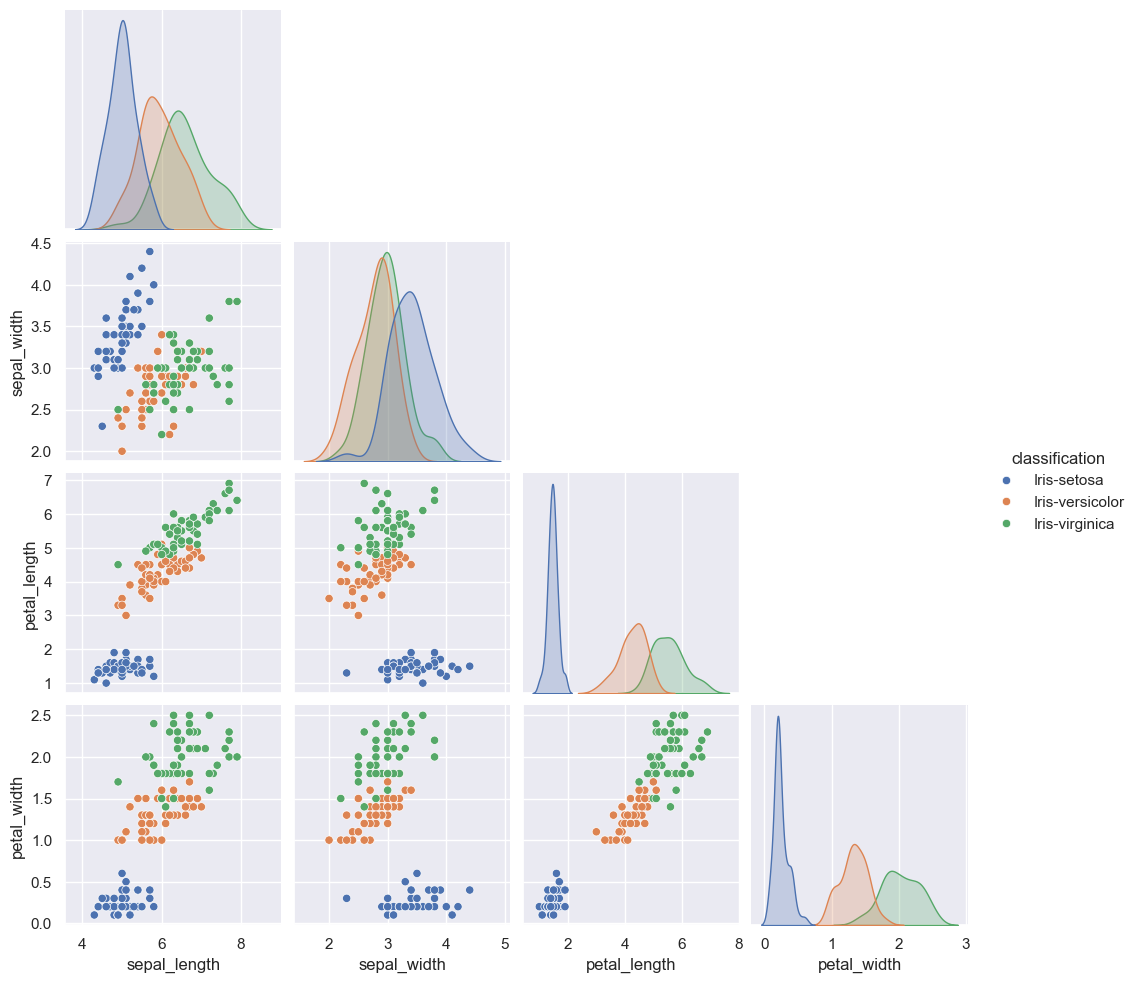

In [56]:
sns.pairplot(iris, hue='classification', corner=True)


## Part H — extended worked examples

This section adds more practice by combining pandas summaries with seaborn plots.
You will:
- build a tidy summary table
- visualize it
- interpret the result and note the next action you would take in a modeling workflow


### 1) Diamonds: price distribution by cut


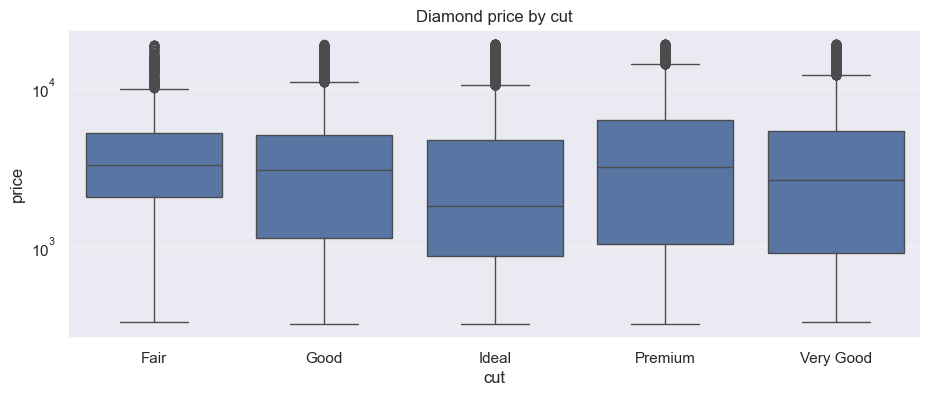

In [57]:
diamonds = diamonds.copy()
plt.figure(figsize=(11, 4))
sns.boxplot(data=diamonds, x='cut', y='price')
plt.title('Diamond price by cut')
plt.yscale('log')
plt.grid(True, axis='y', alpha=0.3)
plt.show()


We used a log scale for price because price distributions are typically right-skewed.
Log scaling often makes comparisons across groups more informative.


### 2) House prices: interaction between neighborhood and brick


In [58]:
house = load_csv(DATASETS['house']).copy()
house['Brick'] = house['Brick'].astype('category')

summary = house.groupby(['Neighborhood', 'Brick']).agg(
    n=('Home', 'size'),
    price_mean=('Price', 'mean'),
    price_median=('Price', 'median')
).reset_index()
summary


C:\Users\LENOVO.PIESC\AppData\Local\Temp\ipykernel_21812\943055010.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = house.groupby(['Neighborhood', 'Brick']).agg(


,Neighborhood,Brick,n,price_mean,price_median
0,East,No,26,117750.000000,116050.0
1,East,Yes,19,135468.421053,135000.0
2,North,No,37,108583.783784,109700.0
3,North,Yes,7,118457.142857,112300.0
4,West,No,23,148230.434783,145800.0
5,West,Yes,16,175200.000000,171750.0


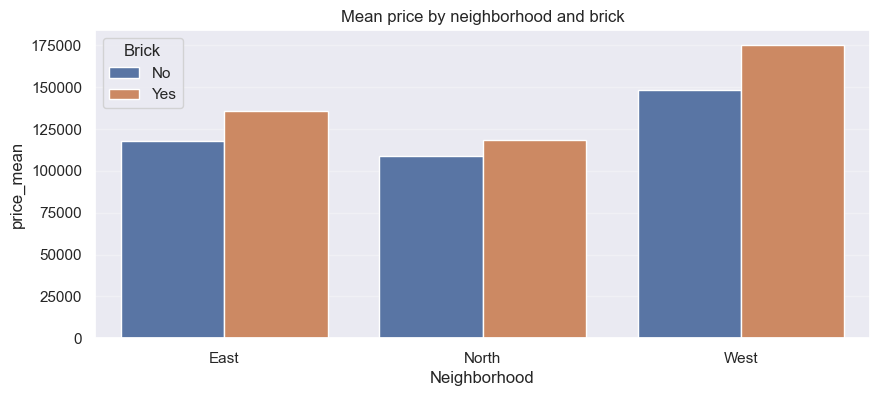

In [59]:
plt.figure(figsize=(10, 4))
sns.barplot(data=summary, x='Neighborhood', y='price_mean', hue='Brick')
plt.title('Mean price by neighborhood and brick')
plt.grid(True, axis='y', alpha=0.3)
plt.show()


## Part I — practice tasks (with reference solutions)

Complete these tasks to consolidate the lesson. Try solving each one before looking at the reference solution.

1. **Iris:** compute the mean and standard deviation of each numeric feature per class.
2. **Wine:** create `sulfur_total_ratio = total sulfur dioxide / free sulfur dioxide` and summarize it by `quality`.
3. **Diamonds:** find the top 10 most expensive diamonds and inspect their `cut`, `color`, and `clarity`.
4. **House:** compare price distributions across neighborhoods using a seaborn plot.
5. **Airports:** compute the number of airports per `iso_country` and list the top 15.
6. **Earthquake:** plot the distribution of `magnitude` and compute the 95th percentile.



In [60]:
iris.groupby('classification').agg(['mean', 'std'])


sepal_length           sepal_width           petal_length           petal_width          
                        mean       std        mean       std         mean       std        mean       std
classification                                                                                           
Iris-setosa            5.006  0.352490       3.418  0.381024        1.464  0.173511       0.244  0.107210
Iris-versicolor        5.936  0.516171       2.770  0.313798        4.260  0.469911       1.326  0.197753
Iris-virginica         6.588  0.635880       2.974  0.322497        5.552  0.551895       2.026  0.274650

In [61]:
wine2 = wine.copy()
wine2['sulfur_total_ratio'] = wine2['total sulfur dioxide'] / wine2['free sulfur dioxide'].replace(0, np.nan)
wine2.groupby('quality')['sulfur_total_ratio'].agg(['count', 'mean', 'median']).sort_index()


,count,mean,median
quality,,,
3,20,6.435765,5.047176
4,153,8.157276,6.400000
5,1175,5.235103,4.239130
6,1788,4.483368,3.898718
7,689,4.067805,3.648649
8,131,3.890031,3.459459
9,5,3.770253,3.645161


In [62]:
diamonds.sort_values('price', ascending=False).head(10)[['price', 'carat', 'cut', 'color', 'clarity']]


,price,carat,cut,color,clarity
27749,18823,2.29,Premium,I,VS2
27748,18818,2.00,Very Good,G,SI1
27747,18806,1.51,Ideal,G,IF
27746,18804,2.07,Ideal,G,SI2
27745,18803,2.00,Very Good,H,SI1
27744,18797,2.29,Premium,I,SI1
27742,18795,2.04,Premium,H,SI1
27743,18795,2.00,Premium,I,VS1
27741,18791,2.15,Ideal,G,SI2
27740,18791,1.71,Premium,F,VS2


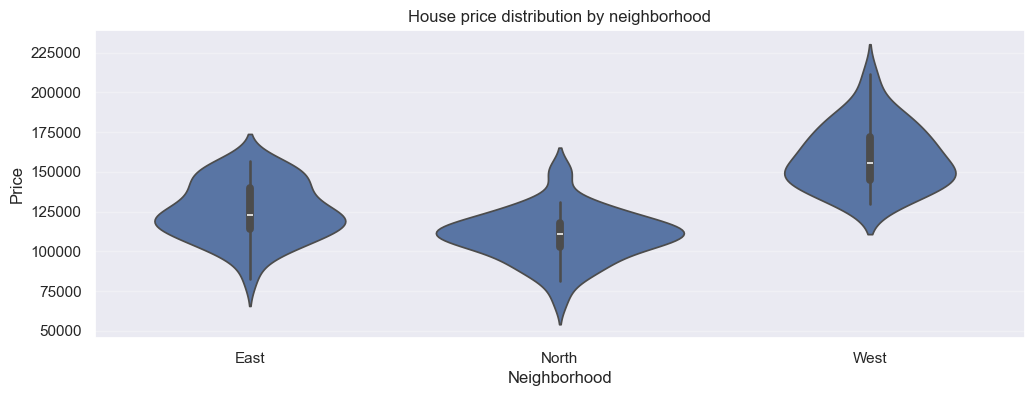

In [63]:
plt.figure(figsize=(12, 4))
sns.violinplot(data=house, x='Neighborhood', y='Price')
plt.title('House price distribution by neighborhood')
plt.grid(True, axis='y', alpha=0.3)
plt.show()


In [64]:
airports_small = load_csv(DATASETS['airports'], usecols=['type', 'iso_country', 'iata_code'])
airports_small['iso_country'].value_counts().head(15)


iso_country
US    32098
BR     7534
JP     3744
CA     3287
AU     2754
MX     2685
RU     1736
FR     1717
GB     1570
KR     1408
DE     1400
AR      956
IT      942
PH      846
CN      743
Name: count, dtype: int64

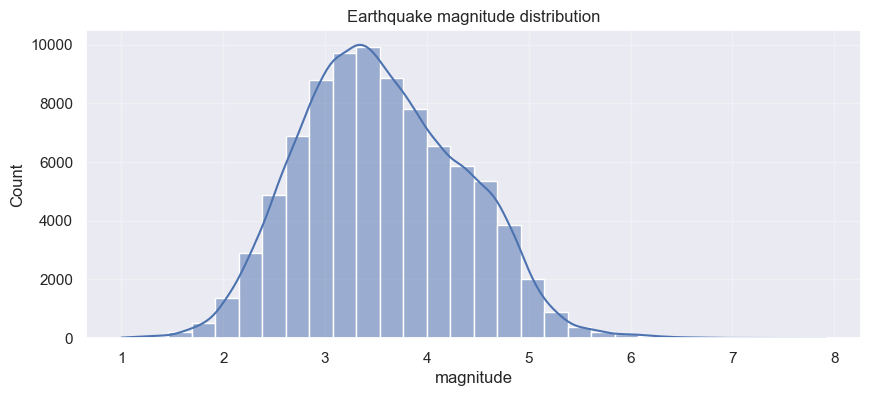

np.float64(4.88)

In [65]:
plt.figure(figsize=(10, 4))
sns.histplot(eq['magnitude'], bins=30, kde=True)
plt.title('Earthquake magnitude distribution')
plt.grid(True, alpha=0.3)
plt.show()

eq['magnitude'].quantile(0.95)


## Summary

In this lesson you practiced the core EDA tooling stack:
- **pandas** for inspection, filtering, grouping, pivoting, reshaping, and quick reporting
- **matplotlib** for foundational plotting, annotations, subplots, scaling, and exporting figures
- **seaborn** for concise statistical visualizations, faceting, and correlation views

You also practiced applying the same workflow across multiple datasets with very different schemas.

A strong next step is to turn your favorite pieces of this notebook into a personal EDA template that you reuse in every project.
